# Song Genre Classification

In this project we will use the music dataset to classify a song into different genres using parameters generated by the Spotify system.

The following are the datasets:
1. https://www.kaggle.com/iamsumat/spotify-top-2000s-mega-dataset
2. https://www.kaggle.com/leonardopena/top-spotify-songs-from-20102019-by-year?select=top10s.csv

We are using 2 datasets to increase the number of samples we can use to train our model. Both the datasets have similar features but slightly differ in terms of their actual labels (song genres)

1. Genre - the genre of the track
2. Year - the release year of the recording.
3. Beats Per Minute (BPM) - The tempo of the song.
4. Energy - The energy of a song
5. Danceability - The higher the value, the easier it is to dance to this song.
6. Loudness (dB) - The higher the value, the louder the song.
7. Liveness - The higher the value, the more likely the song is a live recording.
8. Valence - The higher the value, the more positive mood for the song.
9. Length - The duration of the song.
10. Acousticness - The higher the value the more acoustic the song is.
11. Speechiness - The higher the value the more spoken word the song contains.
12. Popularity - The higher the value the more popular the song is.

Importing required libraries

In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score,f1_score,classification_report

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

## Preparing and cleaning the datasets

In this section we will import our required data and try to clean the values. We will drop any unnecessary columns which are not required for our analysis.

In [143]:
song_df1 = pd.read_csv('Spotify-2000.csv')
song_df2 = pd.read_csv('top10s.csv', engine='python')

In [144]:
display(song_df1.head())

display(song_df1.info())

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Index                   1994 non-null   int64 
 1   Title                   1994 non-null   object
 2   Artist                  1994 non-null   object
 3   Top Genre               1994 non-null   object
 4   Year                    1994 non-null   int64 
 5   Beats Per Minute (BPM)  1994 non-null   int64 
 6   Energy                  1994 non-null   int64 
 7   Danceability            1994 non-null   int64 
 8   Loudness (dB)           1994 non-null   int64 
 9   Liveness                1994 non-null   int64 
 10  Valence                 1994 non-null   int64 
 11  Length (Duration)       1994 non-null   object
 12  Acousticness            1994 non-null   int64 
 13  Speechiness             1994 non-null   int64 
 14  Popularity              1994 non-null   int64 
dtypes: i

None

In [145]:
display(song_df2.head())

display(song_df2.info())

,Unnamed: 0,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,2,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,3,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,4,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,5,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  603 non-null    int64 
 1   title       603 non-null    object
 2   artist      603 non-null    object
 3   top genre   603 non-null    object
 4   year        603 non-null    int64 
 5   bpm         603 non-null    int64 
 6   nrgy        603 non-null    int64 
 7   dnce        603 non-null    int64 
 8   dB          603 non-null    int64 
 9   live        603 non-null    int64 
 10  val         603 non-null    int64 
 11  dur         603 non-null    int64 
 12  acous       603 non-null    int64 
 13  spch        603 non-null    int64 
 14  pop         603 non-null    int64 
dtypes: int64(12), object(3)
memory usage: 70.8+ KB


None

We will only need the numeric attributes (features) of the song like BPM, Energy, Danceability, Loudness etc. So let's drop the unwanted columns and combine the 2 datasets

In [146]:
song_df1.drop(columns=['Index','Title', 'Artist', 'Year'], inplace=True)
song_df2.drop(columns=['Unnamed: 0', 'title', 'artist', 'year'], inplace=True)

song_df1.columns = ['genre', 'bpm', 'energy',	'dnce','dB','live','val','dur','acous','spch','pop']
song_df2.columns = ['genre', 'bpm', 'energy',	'dnce','dB','live','val','dur','acous','spch','pop']

songs_df = song_df1.append(song_df2).reset_index(drop=True)
songs_df.head()

,genre,bpm,energy,dnce,dB,live,val,dur,acous,spch,pop
0,adult standards,157,30,53,-14,11,68,201,94,3,71
1,album rock,135,79,50,-11,17,81,207,17,7,39
2,alternative hip hop,168,69,66,-9,7,52,341,2,17,69
3,alternative metal,173,96,43,-4,3,37,269,0,4,76
4,classic rock,106,82,58,-5,10,87,256,1,3,59


Now that we have a combined dataset, we need to check if all the records are clean and do not have any NaN values. 

We will also check if the columns has appropriate dtypes and convert them using the pandas.infer_objects() function

In [147]:
# Some numeric columns like 'dur' (duration) have their dtype as object. This is because the numeric values have 'comma' in them.
# We will replace them and convert the column to int

for col in songs_df.columns:
  if col == 'genre':
    continue
  attribute = songs_df[col]
  for i, val in enumerate(attribute):
    if(type(val) == str):
      songs_df[col][i] = int(val.replace(',',''))

songs_df = songs_df.infer_objects()

print('Checking the dtypes of all columns:\n')
display(songs_df.info())

print('\n\nChecking if any columns have Nan/Null values after conversion:')
print(songs_df.isnull().values.any())

Checking the dtypes of all columns:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2597 entries, 0 to 2596
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   genre   2597 non-null   object
 1   bpm     2597 non-null   int64 
 2   energy  2597 non-null   int64 
 3   dnce    2597 non-null   int64 
 4   dB      2597 non-null   int64 
 5   live    2597 non-null   int64 
 6   val     2597 non-null   int64 
 7   dur     2597 non-null   int64 
 8   acous   2597 non-null   int64 
 9   spch    2597 non-null   int64 
 10  pop     2597 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 223.3+ KB


None



Checking if any columns have Nan/Null values after conversion:
False


## Data Summary and statistics 

Now that we have a clean dataset, we will check some statistics such as 
1. The distribution of records into various classes (genre). 
2. The spread in the values of each attribute (features).
3. Unique labels (genre) in the data

In [148]:
songs_df.describe()

,bpm,energy,dnce,dB,live,val,dur,acous,spch,pop
count,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000
mean,119.827878,62.192915,55.825183,-8.212168,18.724682,50.062765,253.673854,25.484020,5.775895,61.150558
std,27.316104,21.433564,15.638844,3.758918,15.965464,24.358683,85.153507,27.997266,5.465946,14.687606
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,93.000000,0.000000,0.000000,0.000000
25%,100.000000,46.000000,45.000000,-10.000000,9.000000,30.000000,208.000000,3.000000,3.000000,52.000000
50%,120.000000,65.000000,56.000000,-7.000000,12.000000,49.000000,237.000000,13.000000,4.000000,64.000000
75%,134.000000,80.000000,67.000000,-6.000000,23.000000,69.000000,277.000000,43.000000,6.000000,72.000000
max,206.000000,100.000000,97.000000,-2.000000,99.000000,99.000000,1412.000000,99.000000,55.000000,100.000000


In [162]:
print('Number of unique genre labels:', len(songs_df.genre.unique()))
print('\n\n', songs_df.genre.value_counts())

Number of unique genre labels: 20


 rock                789
edm                 533
pop                 440
country             135
adult standards     123
metal                93
dutch cabaret        51
hip hop              43
permanent wave       42
british soul         42
british invasion     36
neo mellow           26
punk                 23
boy band             21
disco                18
big room             17
dutch americana      12
classic soul         11
mellow gold          11
big beat             11
Name: genre, dtype: int64


We notice that a lot of labels have less than 10 records. These are too less to create a proper prediction. 

Hence, we will try to combine most of the labels in broader catagories.
For example, "Dance pop" and "dutch pop" can just we combined into a since category of "pop"

Most of the logic for this mapping has to be defined manually by understanding the context of the data. There is no generic rule that can be applied for this mapping. Here we use if-else ladder to identify common genres and remap them.

In [151]:
pd.options.mode.chained_assignment = None # Setting this to avoid slice copy warning in the output

# Mapping different genres to a broader genre
for i in range(len(songs_df)):
  if 'metal' in str(songs_df.genre[i]):
    songs_df.genre[i] = 'metal'
  elif any(g in str(songs_df.genre[i]) for g in ['house', 'dance', 'edm', 'electro', 'trance']):
    songs_df.genre[i] = 'edm'
  elif any(g in str(songs_df.genre[i]) for g in ['folk', 'country', 'indie']):
    songs_df.genre[i] = 'country'
  elif any(g in str(songs_df.genre[i]) for g in ['funk', 'punk']):
    songs_df.genre[i] = 'punk'
  elif 'pop' in str(songs_df.genre[i]):
    songs_df.genre[i] = 'pop'
  elif 'rock' in str(songs_df.genre[i]):
    songs_df.genre[i] = 'rock'
  elif 'jazz' in str(songs_df.genre[i]):
    songs_df.genre[i] = 'jazz'
  elif 'hip' in str(songs_df.genre[i]):
    songs_df.genre[i] = 'hip hop'

# Collecting Genres with less than 10 records
genre_to_drop = []
for g in songs_df.genre.unique():
  if len(songs_df[songs_df.genre==g]) <= 10:
    genre_to_drop.append(g)

# Dropping genres with less than 10 records
for g in genre_to_drop:
  songs_df = songs_df.loc[songs_df.genre != g]

With this, we were able to cut down the 167 distinct labels and generate only 20 unique labels to fit the data into.

In [163]:
print('Unique genres:',len(songs_df.genre.unique()))
print('Total records after dropping unwanted genres:',len(songs_df))
print('\n',songs_df.genre.value_counts())

Unique genres: 20
Total records after dropping unwanted genres: 2477

 rock                789
edm                 533
pop                 440
country             135
adult standards     123
metal                93
dutch cabaret        51
hip hop              43
permanent wave       42
british soul         42
british invasion     36
neo mellow           26
punk                 23
boy band             21
disco                18
big room             17
dutch americana      12
classic soul         11
mellow gold          11
big beat             11
Name: genre, dtype: int64


## Problem Statement

At this point we have our input dataset ready. 
Now, we dive into the actual problem of classifying the given songs into their respective genres.

Here, 
1. Our output labels will be the 20 unique genres we have generated.
2. We will use various classification algorithms and compare their performance. 
3. We will also try to use an unsupervised method called PCA: principal component analysis, to reduce the dimensionality of the data and check its impact on classification

### Scaling the features using standard scaler

In [221]:
train_set, test_set = train_test_split(songs_df, test_size = 0.2)

# training set
X_train = train_set.values[:,1:]
y_train = train_set.values[:,0]

# test set
X_test = test_set.values[:,1:]
y_test = test_set.values[:,0]

In [322]:
sscaler = StandardScaler().fit(X_train)

# Standard Scaler
X_train_scaled = sscaler.transform(X_train)
X_test_scaled = sscaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((1981, 10), (496, 10))

### Encoding the output labels

Since our output labels are catagorical, we have to encode them.
There are 2 possibilities:
1. One hot encoding: converting the labels into binary format. 
2. Label encoding: converting labels into a numeric sequence representations

The problem with One hot encoding is that it suffers from the curse of dimensionality when there are large number of output labels.
However, since we are using PCA, we will go with One hot encoding as it tends to give better performance compared to labelEncoding

In [223]:
distinct_labels = np.array(songs_df.genre.unique())
y_test_OHE = label_binarize(y_test, classes = distinct_labels)
y_train_OHE = label_binarize(y_train, classes = distinct_labels)

lbEncoder = LabelEncoder()
train_set['genre_enc'] = lbEncoder.fit_transform(train_set['genre'])

## Feature selection

This is the section where we use PCA to determine the best features that can be used to explain the variance in our dataset.

But first, lets try and use Pearson Correlation to understand the variance in our data manually

### Correlation Matrix

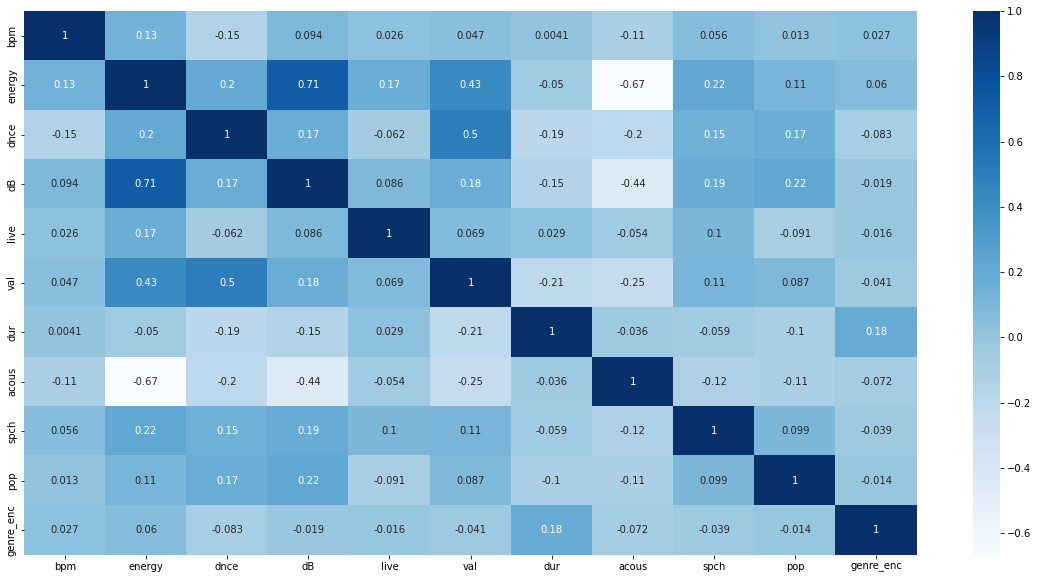

In [224]:
train_correlation = train_set.corr()
plt.figure(figsize=(20,10))
sns.heatmap(train_correlation, annot=True, cmap='Blues')

### Principal Component Analysis
Using PCA to determine the principal components in the feature set

In [225]:
comp = []
var_ratio = []
for k in range(10): # 10 features in the set
  pca_model = PCA(k+1)
  pca_model.fit_transform(X_train_scaled)
  comp.append(k+1)
  var_ratio.append(sum(pca_model.explained_variance_ratio_))

Text(0, 0.5, 'total variance')

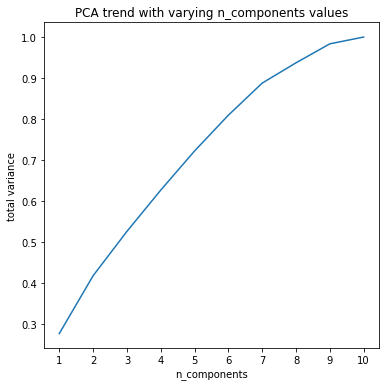

In [266]:
PCA_stats = pd.DataFrame({'Components': comp, 'Variance': var_ratio})
plt.figure(figsize=(6,6))
plt.plot(PCA_stats.Components, PCA_stats.Variance)
plt.xticks(range(1,11))
plt.title('PCA trend with varying n_components values')
plt.xlabel('n_components')
plt.ylabel('total variance')

We notice that 5 components give about 70% of the total information in our data. Hence we will use 5 as n_components in our PCA.

In [267]:
pca_model = PCA(5)
X_train_pca = pca_model.fit_transform(X_train_scaled)
print(pca_model.explained_variance_ratio_)

[0.27570935 0.14129629 0.108317   0.10078449 0.09564417]


Visualizing the principal components of dataset using the top 3 genre based on sample size

From the visual, we can say that some variance was captured using PCA. Points falling in the same genre are closer, and the ones that are very different semantically are further away from each other.

Text(0, 0.5, 'Principal Component 2')

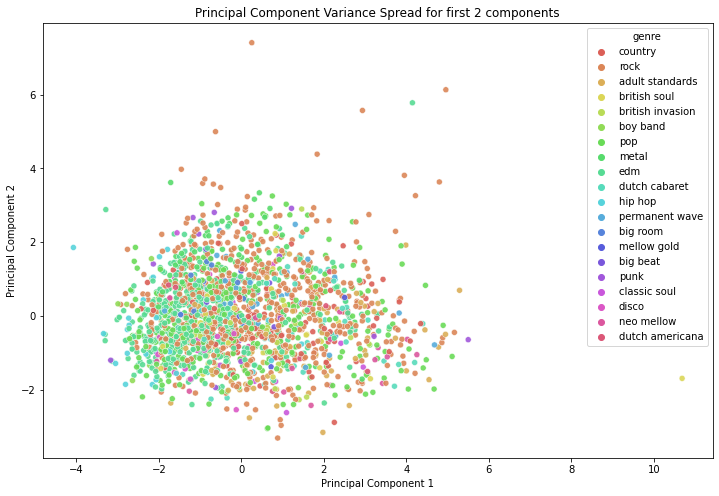

In [282]:

X_train_pca_df = pd.DataFrame(X_train_pca, columns=['pc1', 'pc2','pc3', 'pc4','pc5'])
X_train_pca_df['genre'] = y_train
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="pc1", y="pc2",
    hue="genre",
    palette=sns.color_palette("hls", 20),
    data=X_train_pca_df,
    legend="full",
    alpha=0.9
)
plt.title('Principal Component Variance Spread for first 2 components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

## Classification

### Initializing the models

We will use a list to store all the models we want to test.
This list will serve as a pipeline to iterate over all the models and train them

Through some trial and error, the best results are obtained when the following hyperparameters are used in the respective models: 
1. Perceptron model: ReLU activation with 2 hidden layers of 10 and 5 neurons. We are using the ADAM solver
2. KNN: We use k=10 for the neighbours


In [300]:
models = []
models += [['Neural', MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(10,5,),max_iter=5000)]]
models += [['KNN', KNeighborsClassifier(10)]]
models += [['Logistic', LogisticRegression(multi_class = 'ovr')]]

### Training the models

To train the model, we will use the Stratified K-Fold validation to keep the model from overfitting. Here, we have chosen 5 as the number of folds and we are also re-shuffling the data



In [301]:
output = []

# Use k-fold validation to keep the model from overfitting and produce a generalized fit on the training data
cross_val_set = StratifiedKFold(n_splits = 5, shuffle = True)

for name, model in models:
  cross_eval_scr = cross_val_score(model, X_train_pca, y_train, cv = cross_val_set, scoring = 'accuracy')
  output.append(cross_eval_scr)
  print('{}: {} ({})'.format(name,cross_eval_scr.mean(), cross_eval_scr.std()))

Neural: 0.39119660076838914 (0.02571210701795824)
KNN: 0.3664961962191181 (0.016305070689419)
Logistic: 0.3796007938325318 (0.015224152812201203)


From the accuracy results above, we can see that the neural network performs the best, albeit by a very small margin. We will continue to calculate other performance metrics for these classifiers.

We notice from the results that the perceptron based classifier is still the best among the tested models. 

In [308]:
score_precision_recall = []

for name, model in models:
    y_pred = cross_val_predict(model, X_train_pca, y_train, cv = cross_val_set)
    precision = precision_score(y_train, y_pred, average='micro')
    recall = recall_score(y_train, y_pred, average='micro')
    f1 = f1_score(y_train,y_pred, average='micro')
    
    score_precision_recall += [[name , precision, recall, f1]]
    print('{} ||\tPrecision: {},\tRecall: {},\tF1: {}'.format(name, precision, recall, f1))

Neural ||	Precision: 0.38213023725391215,	Recall: 0.38213023725391215,	F1: 0.38213023725391215
KNN ||	Precision: 0.35487127713276123,	Recall: 0.35487127713276123,	F1: 0.3548712771327613
Logistic ||	Precision: 0.3806158505805149,	Recall: 0.3806158505805149,	F1: 0.3806158505805149


### Testing the model

Using the Perceptron based model to predict the labels for the test set

In [310]:
perceptron = MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(10,5,),max_iter=5000)
perceptron.fit(X_train_pca, y_train)

X_test_pca = pca_model.transform(X_test_scaled)
y_test_pred = perceptron.predict(X_test_pca)

### Output performance metrics


In [321]:
p = precision_score(y_test, y_test_pred, average='micro')
r = recall_score(y_test, y_test_pred, average='micro')
f = f1_score(y_test, y_test_pred, average='macro')

print('Final Performance metrics on test set:\n')
print('Precision:{}\nRecall:{}\nF1 Score:{}'.format(p,r,f))

Final Performance metrics on test set:

Precision:0.4173387096774194
Recall:0.4173387096774194
F1 Score:0.07989085209461384


Text(0.5, 1.0, 'Confusion Matrix for songs dataset')

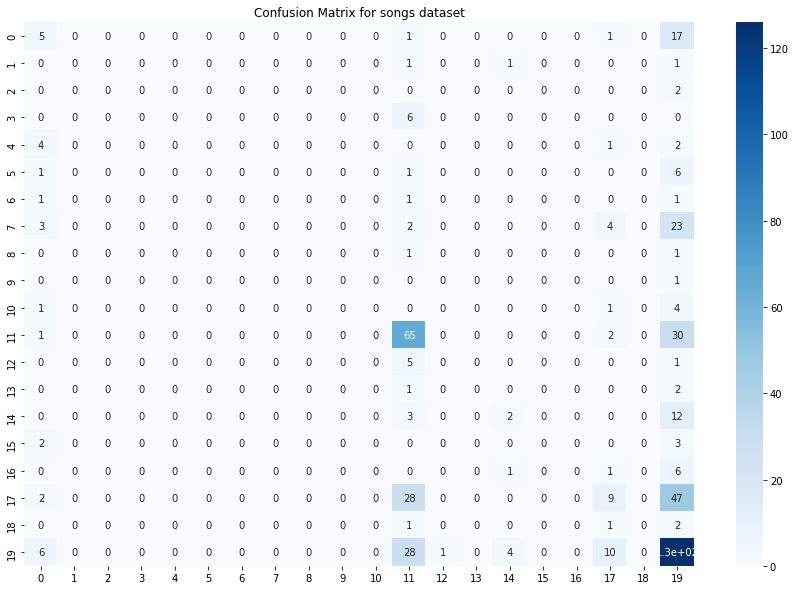

In [317]:
plt.figure(figsize=(15,10))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, cmap='Blues')
plt.title('Confusion Matrix for songs dataset')

# Conclusion

### Observations: 
1. It can be noticed from the correlation matrix that the features do not correlate well with the output labels with the highest correlation of 0.18 between genre and duration (which logically does not make any sense).
2. The results from principal component analysis are not satisfactory. The variance produced by the principal features does not clearly classify the available data.
3. The final accuracy of the model is just 0.39 which is not great.

### Insights
Although the final performance metrics of the model are not impressive, we can still gather some insights of how to improve the model

1. Increasing the sample size. 
> A sample size of just 2000 records for a classification problem of more than 150 unique classes is not sufficient. Increasing the overall sample size and also the per-class sample can improve classification results significantly.
2. Better labeling of output.
> Here we used a custom mapping to combine multiple output genres (labels) under a broader term to reduce the dimensionality of the output. However, it is possible that doing so caused the overlap between key attributes (or their values) that could be used to distinguish the genre and the model was unable to learn these differences. 
>> For example: We combined "dance pop" and "indie pop" under a common label "pop"; but it could be the case that these genres have very distinct sound signatures and combining them under a single label forced the model to overlook these differences 
3. Choosing better Classifiers/hyperparameters
> A lot more research can be done to fine tune the hyper-parameters of the existing models used in this project to better fit the input data. We could also explore additional classifiers like Random Forest, Support Vector Machines etc which could perform better.